In [ ]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import glob

print("Libraries imported successfully.")


Libraries imported successfully.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow pandas


Mounted at /content/drive
Loading annotation and class names files...

Sample of cleaned DataFrame:
                                            filename  class  \
0  /content/drive/MyDrive/Model Recognition/train...     14   
1  /content/drive/MyDrive/Model Recognition/train...      3   
2  /content/drive/MyDrive/Model Recognition/train...     91   
3  /content/drive/MyDrive/Model Recognition/train...    134   
4  /content/drive/MyDrive/Model Recognition/train...    106   

                                folder  
0                  Audi TTS Coupe 2012  
1                  Acura TL Sedan 2012  
2           Dodge Dakota Club Cab 2007  
3     Hyundai Sonata Hybrid Sedan 2012  
4  Ford F-450 Super Duty Crew Cab 2012  

Checking file existence for the first image:
First file exists: True

Setting up the ImageDataGenerator with augmentation...
Found 6483 validated image filenames belonging to 195 classes.
Found 1620 validated image filenames belonging to 195 classes.

Data generators are re

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 3590s 17s/step - accuracy: 0.0075 - loss: 5.3404 - val_accuracy: 0.0284 - val_loss: 5.1207
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 162s 800ms/step - accuracy: 0.0616 - loss: 4.8287 - val_accuracy: 0.0568 - val_loss: 4.6645
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 150s 739ms/step - accuracy: 0.1699 - loss: 3.9454 - val_accuracy: 0.1370 - val_loss: 3.9881
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 148s 728ms/step - accuracy: 0.3196 - loss: 2.9318 - val_accuracy: 0.2494 - val_loss: 3.2445
Epoch 5/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 149s 733ms/step - accuracy: 0.4510 - loss: 2.2658 - val_accuracy: 0.3512 - val_loss: 2.7233
Epoch 6/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 148s 727ms/step - accuracy: 0.5644 - loss: 1.7239 - val_accuracy: 0.4346 - val_loss: 2.3210
Epoch 7/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 143s 706ms/step - accuracy: 0.6645 - loss: 1.3432 - val_accuracy: 0.5253 - val_loss: 1.9604
Epoch 8/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 146s 718ms/step - accuracy: 0.7321 - 


Training complete.

Model saved to /content/drive/MyDrive/vehicle_make_model_finetuned.h5.


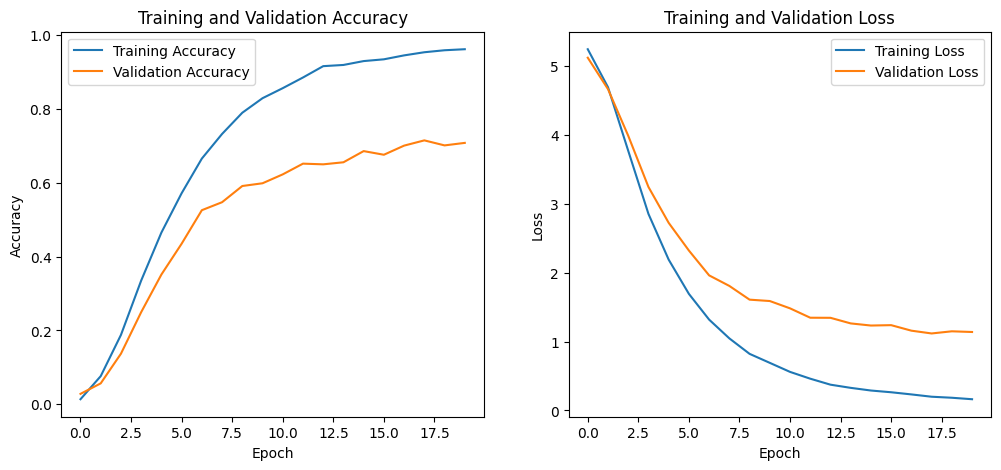

In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import glob

# Step 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 3: Set the data directory
data_dir = '/content/drive/MyDrive/Model Recognition'
os.chdir(data_dir)

# Step 4: Load the annotations and class names files
print("Loading annotation and class names files...")
train_ann = pd.read_csv("anno_train.csv", header=None, usecols=[0, 5], names=["filename", "class"])
label_names = pd.read_csv("names.csv", header=None, names=["class_name"])

# Step 5: Map class IDs to folder names
label_map = dict(zip(range(1, len(label_names) + 1), label_names['class_name']))
train_ann['folder'] = train_ann['class'].map(label_map)

# Step 6: Construct the full file path
train_ann['filename'] = train_ann.apply(
    lambda x: f"{data_dir}/train/{x['folder']}/{x['filename']}", axis=1
)

# Step 7: Remove the problematic class (if any)
missing_class = "Ram C/V Cargo Van Minivan 2012"
train_ann = train_ann[train_ann['folder'] != missing_class]

# Step 8: Verify the updated paths
print("\nSample of cleaned DataFrame:")
print(train_ann.head())
print("\nChecking file existence for the first image:")
print("First file exists:", os.path.exists(train_ann['filename'].iloc[0]))

# Step 9: Data Augmentation and Data Generator Setup
print("\nSetting up the ImageDataGenerator with augmentation...")
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,   # 80-20 split
    rotation_range=15,      # Random rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1, # Vertical shift
    shear_range=0.15,       # Shearing
    zoom_range=0.1,         # Zooming
    horizontal_flip=True,   # Horizontal flip
    fill_mode='nearest'     # Filling empty pixels
)

# Train Data Generator
train_gen = datagen.flow_from_dataframe(
    dataframe=train_ann,
    x_col='filename',
    y_col='folder',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='training',
    shuffle=True
)

# Validation Data Generator
val_gen = datagen.flow_from_dataframe(
    dataframe=train_ann,
    x_col='filename',
    y_col='folder',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='validation',
    shuffle=False
)

# Step 10: Verify that the generators are not empty
if len(train_gen) == 0 or len(val_gen) == 0:
    raise ValueError("The data generators are empty. Please check the file paths and data.")

print("\nData generators are ready.")

# Step 11: Build the Model with Fine-Tuning (MobileNetV2)
print("\nBuilding the model...")
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

# Unfreeze the last 20 layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Construct the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(train_gen.class_indices), activation='softmax')
])

# Step 12: Compile the model with a low learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print("\nModel compiled successfully.")

# Step 13: Train the Model
print("\nStarting training...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,  # Increased epochs for better learning
    verbose=1
)

print("\nTraining complete.")

# Step 14: Save the trained model to Google Drive
model_path = '/content/drive/MyDrive/vehicle_make_model_finetuned.h5'
model.save(model_path)
print(f"\nModel saved to {model_path}.")

# Step 15: Plot Training History
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Model loaded for testing.

Testing single image: /content/drive/MyDrive/Model Recognition/test/smh.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Predicted vehicle make and model: Ford GT Coupe 2006


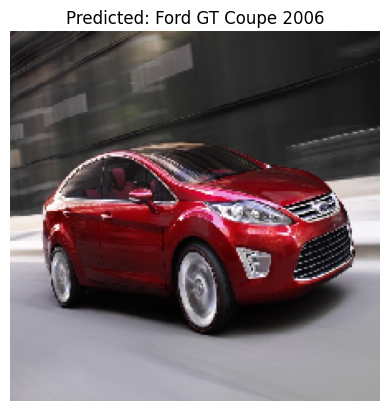


Testing all images in the folder: /content/drive/MyDrive/Model Recognition/test

Found 6 images in the folder '/content/drive/MyDrive/Model Recognition/test'.

Testing image: pls.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

Predicted vehicle make and model: Ford GT Coupe 2006


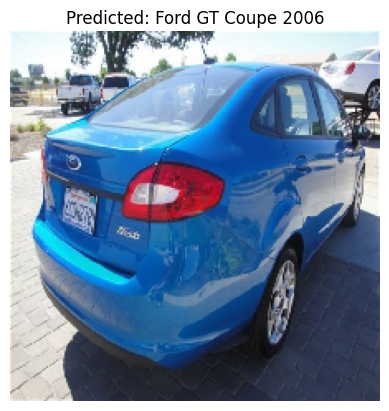


Testing image: smh.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step

Predicted vehicle make and model: Ford GT Coupe 2006


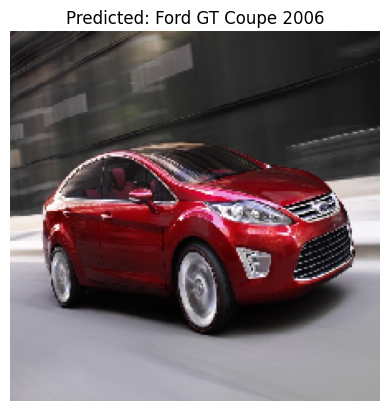


Testing image: download.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

Predicted vehicle make and model: Toyota Sequoia SUV 2012


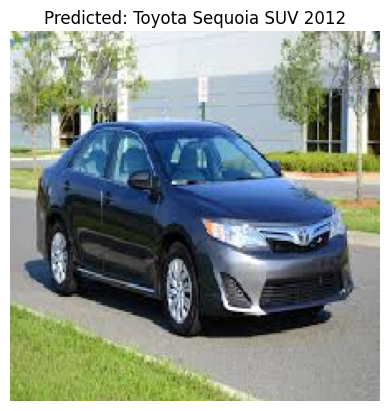


Testing image: idk.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

Predicted vehicle make and model: Acura TL Sedan 2012


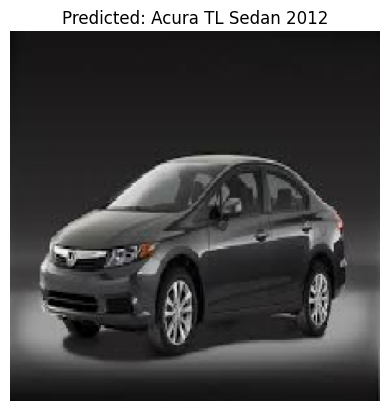


Testing image: idc.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

Predicted vehicle make and model: Acura TL Type-S 2008


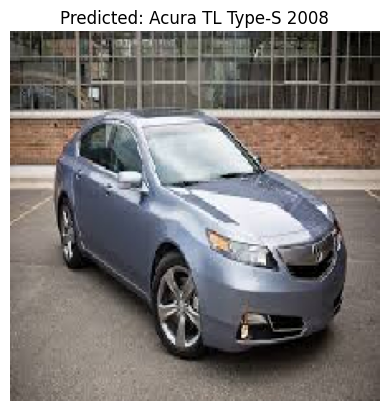


Testing image: mnk.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step

Predicted vehicle make and model: Volkswagen Golf Hatchback 1991


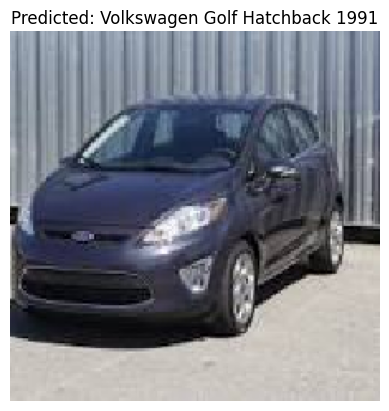

In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
import os
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob

# Step 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 3: Load the trained model from Google Drive
model_path = '/content/drive/MyDrive/vehicle_make_model_finetuned.h5'
model = tf.keras.models.load_model(model_path)
print("\nModel loaded for testing.")

# Step 4: Load class names from the CSV file
label_names = pd.read_csv('/content/drive/MyDrive/Model Recognition/names.csv', header=None, names=["class_name"])
label_map = dict(zip(range(len(label_names)), label_names['class_name']))

# Step 5: Test a Single Image
def test_single_image(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class of the image
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_class_name = label_map[predicted_class]

    # Print the predicted class name
    print(f"\nPredicted vehicle make and model: {predicted_class_name}")

    # Display the image with the predicted class
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

# Path to the test image (change to your actual image path)
test_image_path = '/content/drive/MyDrive/Model Recognition/test/smh.jpg'
print(f"\nTesting single image: {test_image_path}")
test_single_image(test_image_path)

# Step 6: Test Multiple Images from a Folder
def test_multiple_images(folder_path):
    image_files = glob.glob(os.path.join(folder_path, "*.jpg")) + glob.glob(os.path.join(folder_path, "*.jpeg"))
    print(f"\nFound {len(image_files)} images in the folder '{folder_path}'.")

    for img_path in image_files:
        print(f"\nTesting image: {os.path.basename(img_path)}")
        test_single_image(img_path)

# Path to the test folder (change to your actual folder path)
test_folder_path = '/content/drive/MyDrive/Model Recognition/test'
print(f"\nTesting all images in the folder: {test_folder_path}")
test_multiple_images(test_folder_path)
